# Modelos

In [85]:
from src.utils import (
  COLUMNA_OBJETIVO,
  PREDICTORES_NUMERICOS,
  PREDICTORES_CATEGORICOS
)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [86]:
datos = (pd
  .read_csv('census_income/census-income.csv')
  # Excluir las columnas 'key' e 'instance weight'
  [[*PREDICTORES_NUMERICOS, *PREDICTORES_CATEGORICOS, COLUMNA_OBJETIVO]]
)

# Corregir los tipos de variables
for pred_num in PREDICTORES_NUMERICOS:
  datos[pred_num] = pd.to_numeric(datos[pred_num], errors = 'raise')

for pred_cat in PREDICTORES_CATEGORICOS:
  datos[pred_cat] = pd.Categorical(datos[pred_cat])

datos

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,class of worker,detailed industry code,detailed occupation code,...,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed code,fill inc questionnaire for veteran's admin,veterans benefits code,year,taxable income amount
0,73,0,0,0,0,0,0,Not in universe,0,0,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,95,0
1,58,0,0,0,0,1,52,Self-employed-not incorporated,4,34,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,94,0
2,18,0,0,0,0,0,0,Not in universe,0,0,...,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,95,0
3,9,0,0,0,0,0,0,Not in universe,0,0,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,94,0
4,10,0,0,0,0,0,0,Not in universe,0,0,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,0,0,0,Not in universe,0,0,...,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,95,0
199519,65,0,6418,0,9,1,52,Self-employed-incorporated,37,2,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,94,0
199520,47,0,0,0,157,6,52,Not in universe,0,0,...,Not in universe,Poland,Poland,Germany,Foreign born- U S citizen by naturalization,0,Not in universe,2,95,0
199521,16,0,0,0,0,0,0,Not in universe,0,0,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,95,0


## Funciones auxiliares

In [87]:
# Definimos una función que calcule las métricas relevantes
# asociadas a la matriz de confusión, dado el par de parámetros
# datos_observados y datos_predichos
def mostrar_metricas_relevantes_del_modelo(y_observado, y_predicho) -> None:
  """
  Suponemos que ambos parámetros contienen solo elementos 1 y 0,
  donde 1 representa el caso exitoso. Es decir, para este proyecto,
  1 representa cuando la persona debe pagar impuesto.
  """
  tp, fn, fp, tn = confusion_matrix(y_observado, y_predicho, labels = [1, 0]).ravel()
  exactitud = (tp + tn) / (tp + fp + tn + fn)
  sensibilidad = tp / (tp + fn)
  especificidad = tn / (tn + fp)

  print('\nCantidades en la variable por predecir:', y_observado.value_counts())

  print('\nMatriz de confusión:\n', confusion_matrix(y_observado, y_predicho, labels = [1, 0]))
  print(f'\nExactitud: {exactitud}')
  print(f'\nSensibilidad: {sensibilidad}')
  print(f'\nEspecificidad: {especificidad}')

  # Coeficiente de Kappa de Cohen
  print(f'\nCoeficiente de Kappa de Cohen: {cohen_kappa_score(y_observado, y_predicho)}')

  return;

# Definimos una función para calcular la curva ROC y el AUC,
# dado un modelo, ya entrenado y capaz de predecir probabilidad
# de pertenencia a una clase; además de un cojunto de test
def graficar_curva_roc_con_auc(
  nombre_modelo, modelo, predictores_test, target_test
) -> None:
  y_pred_prob = modelo.predict_proba(predictores_test)[:, 1]

  # Calcular curva ROC y su AUC
  fpr, tpr, _ = roc_curve(target_test, y_pred_prob)
  auc_score = roc_auc_score(target_test, y_pred_prob)

  plt.figure(figsize = (8, 6))
  plt.plot(fpr, tpr, label = f"Curva ROC (AUC = {auc_score:.3f})")
  plt.plot([0, 1], [0, 1], 'k--', label = 'Clasificación aleatoria')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("1 - Especificidad")
  plt.ylabel("Sensibilidad")
  plt.title(f"Curva ROC del modelo {nombre_modelo}")
  plt.legend(loc = "lower right")
  plt.show()

  return;

# Definimos una función para calcular el punto de corte óptimo,
# para el mejor equilibrio posible entre sensibilidad y especificidad,
# según el criterio del índice J de Youden
def optimizar_punto_de_corte_segun_criterio_de_youden(
  modelo, predictores_test, target_test
) -> float:
  y_pred_prob = modelo.predict_proba(predictores_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(target_test, y_pred_prob)

  df_youden = pd.DataFrame({'thresholds' : thresholds, 'J': tpr - fpr})
  punto_de_corte_optimo = df_youden[df_youden["J"] == df_youden["J"].max()]["thresholds"].values[0]
  return punto_de_corte_optimo

## Sobre la partición en entrenamiento y test

No es recomendable comparar modelos en base a un mismo conjunto
de test. Esto porque sino podría generarse overfitting respecto
al conjunto de test, perdiendo así generalizabilidad de los modelos.
Aquello en el sentido que podria producirse un 'sesgo de confirmación',
pues sería posible que, tras emplear el mismo conjunto de test para
todos los modelos, no se obtenga el modelo que se adecúe mejor
a otros datos nuevos, sino solo a esa muestra en particular.

En ese sentido, para cada modelo se realizará una partición
diferente en entrenamiento y test.

In [88]:
# Fijamos diferentes semillas para la partición train/test
# en cada modelo
RANDOM_STATE_REG = 42
RANDOM_STATE_BOSQUE = 420
RANDOM_STATE_XGB = 6174

X = pd.get_dummies(
  datos.drop(columns = [COLUMNA_OBJETIVO]),
  columns = PREDICTORES_CATEGORICOS,
  # Descartamos una columna del total de columnas creadas por variable
  # categórica, para intentar evitar multicolinearidad entre los predictores
  drop_first = True,
  dtype = 'int64'
)

y = datos[COLUMNA_OBJETIVO]

## Entrenamiento de modelos

### Regresión logística

In [89]:
from sklearn.linear_model import LogisticRegression

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
  X, y, test_size = 0.2, random_state = RANDOM_STATE_REG
)

In [90]:
# Estandarizamos los predictores
estandarizador = StandardScaler()
X_train_std = estandarizador.fit_transform(X_train_reg)
X_test_std = estandarizador.transform(X_test_reg)

In [91]:
modelo_reg = LogisticRegression(max_iter = 1000, random_state = RANDOM_STATE_REG)
modelo_reg.fit(X_train_std, y_train_reg)

LogisticRegression(max_iter=1000, random_state=42)

In [92]:
# Predicciones del modelo, con punto de corte c = 0.5
y_pred_reg = modelo_reg.predict(X_test_std)
mostrar_metricas_relevantes_del_modelo(y_test_reg, y_pred_reg)


Cantidades en la variable por predecir: taxable income amount
0    37543
1     2362
Name: count, dtype: int64

Matriz de confusión:
 [[  922  1440]
 [  400 37143]]

Exactitud: 0.9538904899135446

Sensibilidad: 0.3903471634208298

Especificidad: 0.9893455504355007

Coeficiente de Kappa de Cohen: 0.4783841414093508


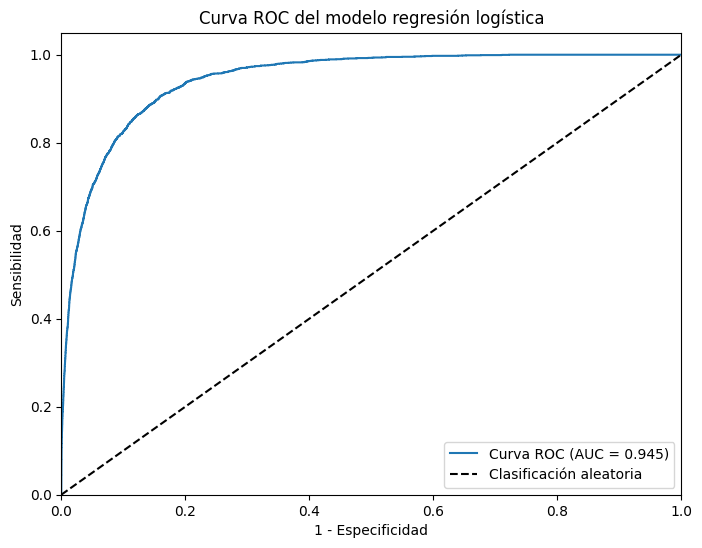

In [93]:
graficar_curva_roc_con_auc(
  nombre_modelo = 'regresión logística',
  modelo = modelo_reg,
  predictores_test = X_test_std,
  target_test = y_test_reg
)

In [94]:
# Calcular el punto de corte para el mejor equilibrio posible
# entre sensibilidad y especificidad
punto_de_corte_optimo_reg = optimizar_punto_de_corte_segun_criterio_de_youden(
  modelo_reg, X_test_std, y_test_reg
)
print(f'Punto de corte óptimo: {punto_de_corte_optimo_reg}')

y_pred_prob_reg = modelo_reg.predict_proba(X_test_std)[:, 1]
y_pred_opt_reg = (y_pred_prob_reg >= punto_de_corte_optimo_reg) + 0

mostrar_metricas_relevantes_del_modelo(y_test_reg, y_pred_opt_reg)

Punto de corte óptimo: 0.05659788672390096

Cantidades en la variable por predecir: taxable income amount
0    37543
1     2362
Name: count, dtype: int64

Matriz de confusión:
 [[ 2142   220]
 [ 6039 31504]]

Exactitud: 0.8431524871569979

Sensibilidad: 0.9068585944115156

Especificidad: 0.8391444476999707

Coeficiente de Kappa de Cohen: 0.3462860241365743


#### Importancia de los predictores

In [95]:
importancia_predictores_reg = pd.DataFrame({
  'Predictor': X.columns,
  # Coeficientes estandarizados
  'Coeficiente': modelo_reg.coef_[0]
})
importancia_predictores_reg = (importancia_predictores_reg
  .assign(abs_coef = lambda d: d['Coeficiente'].abs())
  .sort_values(by = 'abs_coef', ascending = False)
  .loc[:, ['Predictor', 'Coeficiente']]
)

importancia_predictores_reg.head(20)

,Predictor,Coeficiente
6,weeks worked in year,0.926077
204,tax filer stat_ Nonfiler,-0.810896
0,age,0.705328
120,education_ Bachelors degree(BA AB BS),0.548199
186,sex_ Male,0.540214
2,capital gains,0.453010
125,education_ Masters degree(MA MS MEng MEd MSW MBA),0.434471
337,family members under 18_ Mother only present,-0.412428
5,num persons worked for employer,0.387481
194,full or part time employment stat_ Full-time s...,0.380542


**Interpretación**: 
"""
NO OLVIDAR QUE LOS BETA_I SE INTERPRETAN EN BASE Al CAMBIO DEL 
PREDICTOR X_I EN DESVIACION_ESTANDAR(X_I), NO CAMBIO EN 1 NOMÁS.
"""

### Bosque aleatorio

In [96]:
from sklearn.ensemble import RandomForestClassifier

X_train_bosque, X_test_bosque, y_train_bosque, y_test_bosque = train_test_split(
  X, y, test_size = 0.2, random_state = RANDOM_STATE_BOSQUE
)

In [97]:
modelo_bosque = RandomForestClassifier(n_estimators = 100, random_state = RANDOM_STATE_BOSQUE)
modelo_bosque.fit(X_train_bosque, y_train_bosque)

RandomForestClassifier(random_state=420)

In [98]:
y_pred_bosque = modelo_bosque.predict(X_test_bosque)
mostrar_metricas_relevantes_del_modelo(y_test_bosque, y_pred_bosque)


Cantidades en la variable por predecir: taxable income amount
0    37421
1     2484
Name: count, dtype: int64

Matriz de confusión:
 [[  987  1497]
 [  339 37082]]

Exactitud: 0.95399072797895

Sensibilidad: 0.3973429951690821

Especificidad: 0.9909409155287138

Coeficiente de Kappa de Cohen: 0.4962850655936636


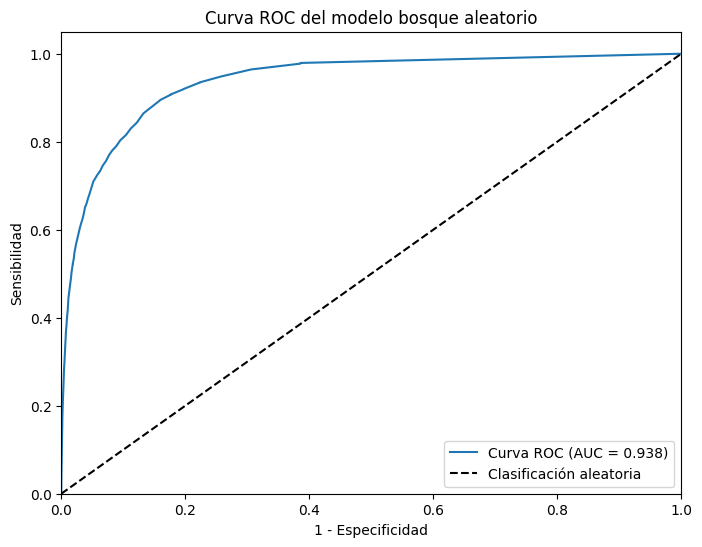

In [99]:
graficar_curva_roc_con_auc(
  nombre_modelo = 'bosque aleatorio',
  modelo = modelo_bosque,
  predictores_test = X_test_bosque,
  target_test = y_test_bosque
)

In [100]:
punto_de_corte_optimo_bosque = optimizar_punto_de_corte_segun_criterio_de_youden(
  modelo_bosque, X_test_bosque, y_test_bosque
)
print(f'Punto de corte óptimo: {punto_de_corte_optimo_bosque}')

y_pred_prob_bosque = modelo_bosque.predict_proba(X_test_bosque)[:, 1]
y_pred_opt_bosque = (y_pred_prob_bosque >= punto_de_corte_optimo_bosque) + 0

mostrar_metricas_relevantes_del_modelo(y_test_bosque, y_pred_opt_bosque)

Punto de corte óptimo: 0.0625

Cantidades en la variable por predecir: taxable income amount
0    37421
1     2484
Name: count, dtype: int64

Matriz de confusión:
 [[ 2223   261]
 [ 5972 31449]]

Exactitud: 0.8438040345821326

Sensibilidad: 0.894927536231884

Especificidad: 0.8404104647123273

Coeficiente de Kappa de Cohen: 0.3546789299045915


#### Importancia de los predictores

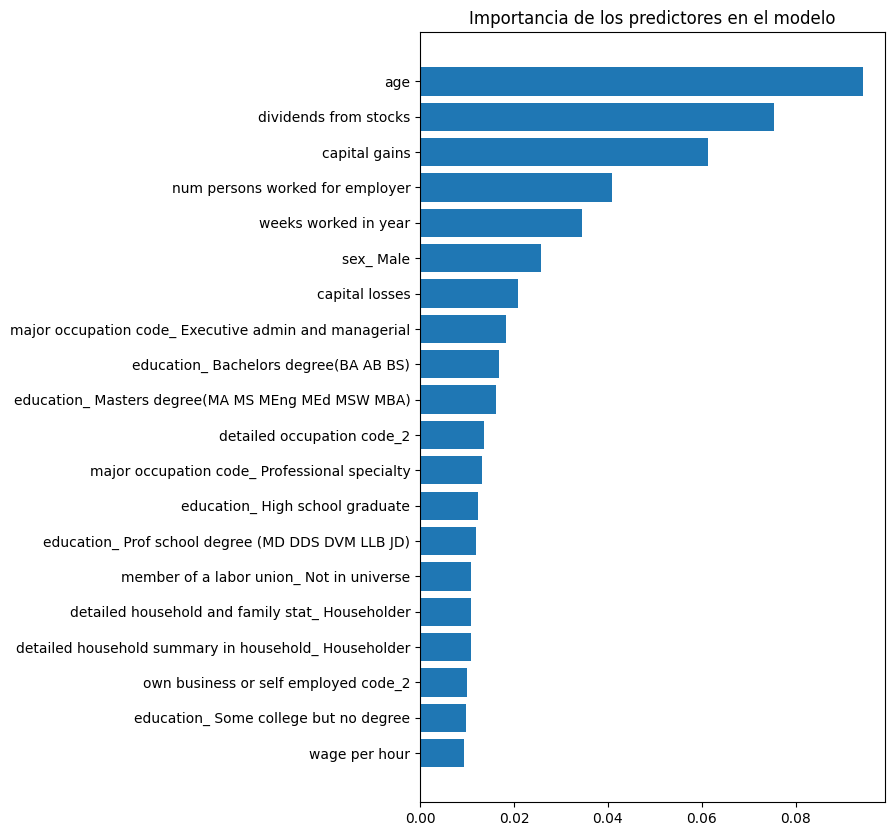

In [101]:
importancia_predictores_bosque = (pd.DataFrame({
  'Predictor' : X.columns,
  'Importancia': modelo_bosque.feature_importances_
})
  .sort_values('Importancia', ascending = True)
  # Seleccionar solo los 20 predictores más importantes
  .tail(20)
)

fig, ax = plt.subplots(figsize = (6, 10))
ax.barh(
  importancia_predictores_bosque['Predictor'].values,
  importancia_predictores_bosque['Importancia'].values
)
plt.title("Importancia de los predictores en el modelo")
plt.show()

### XGBoost

In [102]:
import re
import xgboost as xgb
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold

X_xgb = X.copy()

# Remover los caracteres en los nombres de las columnas que generan
# error al entrenar el modelo
# Fuente: https://stackoverflow.com/a/50633571
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_xgb.columns.values]

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
  X_xgb, y, test_size = 0.2, random_state = RANDOM_STATE_XGB
)

In [103]:
param_grid = { 'alpha': [0.01, 0.1, 1, 10] }

cv = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE_XGB)

proporcion_negativos_positivos = (y.shape[0] - y.sum()) / y.sum()

modelo_cv_xgb = xgb.XGBClassifier(
  # Calculamos la raíz cuadra de la proporción de negativos
  # y positivos, pues la cantidad de casos positivos es tan pequeña
  scale_pos_weight = np.sqrt(proporcion_negativos_positivos),
  use_label_encoder = False,
  random_state = RANDOM_STATE_XGB
)

kappa_scorer = make_scorer(cohen_kappa_score)

grid_search = GridSearchCV(
  estimator = modelo_cv_xgb, 
  param_grid = param_grid, 
  cv = cv, 
  scoring = kappa_scorer, 
  n_jobs = -1,
  verbose = 1
)
grid_search.fit(X_train_xgb, y_train_xgb)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=6174, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     i...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=6174, ...),
             n_jobs=-1, param_grid={'alpha': [0.01, 0.1, 1, 10]},
             scoring=make_scorer(cohen_kappa_score), verbose=1)

In [104]:
modelo_xgb = grid_search.best_estimator_
modelo_xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [105]:
y_pred_xgb = modelo_xgb.predict(X_test_xgb)
mostrar_metricas_relevantes_del_modelo(y_test_xgb, y_pred_xgb)


Cantidades en la variable por predecir: taxable income amount
0    37367
1     2538
Name: count, dtype: int64

Matriz de confusión:
 [[ 1860   678]
 [ 1621 35746]]

Exactitud: 0.9423881719082822

Sensibilidad: 0.7328605200945626

Especificidad: 0.9566194770787058

Coeficiente de Kappa de Cohen: 0.5877127623452704


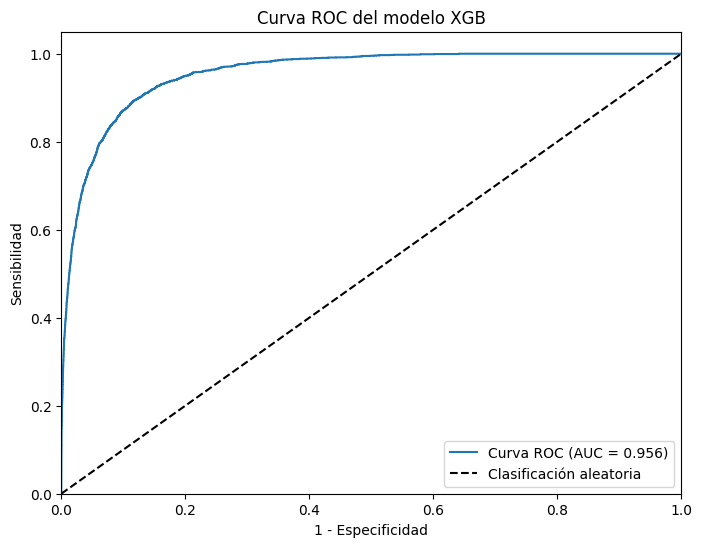

In [106]:
graficar_curva_roc_con_auc(
  nombre_modelo = 'XGB',
  modelo = modelo_xgb,
  predictores_test = X_test_xgb,
  target_test = y_test_xgb
)

In [107]:
punto_de_corte_optimo_xgb = optimizar_punto_de_corte_segun_criterio_de_youden(
  modelo_xgb, X_test_xgb, y_test_xgb
)
print(f'Punto de corte óptimo: {punto_de_corte_optimo_xgb}')

y_pred_prob_xgb = modelo_xgb.predict_proba(X_test_xgb)[:, 1]
y_pred_opt_xgb = (y_pred_prob_xgb >= punto_de_corte_optimo_xgb) + 0

mostrar_metricas_relevantes_del_modelo(y_test_xgb, y_pred_opt_xgb)

Punto de corte óptimo: 0.21816299855709076

Cantidades en la variable por predecir: taxable income amount
0    37367
1     2538
Name: count, dtype: int64

Matriz de confusión:
 [[ 2266   272]
 [ 4337 33030]]

Exactitud: 0.8845006891366997

Sensibilidad: 0.8928289992119779

Especificidad: 0.8839350228811518

Coeficiente de Kappa de Cohen: 0.4447713428748531


#### Importancia de los predictores

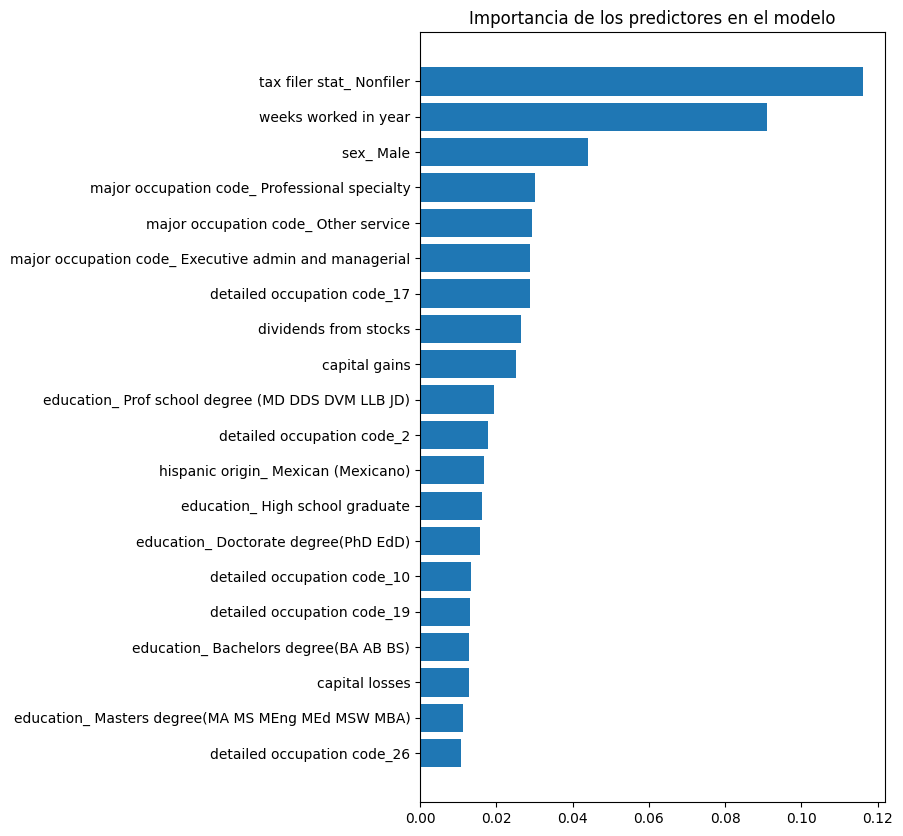

In [108]:
importancia_predictores_xgb = (pd.DataFrame({
  # No es necesario extraer las columns de X_xgb, pues tienen
  # el mismo orden que en X. Emplearemos las columnas de X 
  # por consistencia con los modelos previos.
  'Predictor' : X.columns,
  'Importancia': modelo_xgb.feature_importances_
})
  .sort_values('Importancia', ascending = True)
  # Seleccionar solo los 20 predictores más importantes
  .tail(20)
)

fig, ax = plt.subplots(figsize = (6, 10))
ax.barh(
  importancia_predictores_xgb['Predictor'].values,
  importancia_predictores_xgb['Importancia'].values
)
plt.title("Importancia de los predictores en el modelo")
plt.show()

## Guardamos los modelos

In [109]:
import pickle

In [110]:
with open("modelos/modelo_reg.pkl", "wb") as model_file:
  pickle.dump(modelo_reg, model_file)

with open("modelos/modelo_bosque.pkl", "wb") as model_file:
  pickle.dump(modelo_bosque, model_file)

with open("modelos/modelo_xgb.pkl", "wb") as model_file:
  pickle.dump(modelo_xgb, model_file)

## Comparación de los modelos

In [111]:
with open("modelos/modelo_reg.pkl", "rb") as model_file:
  modelo_reg = pickle.load(model_file)

with open("modelos/modelo_bosque.pkl", "rb") as model_file:
  modelo_bosque = pickle.load(model_file)

with open("modelos/modelo_xgb.pkl", "rb") as model_file:
  modelo_xgb = pickle.load(model_file)

### Curvas ROC y valor AUC

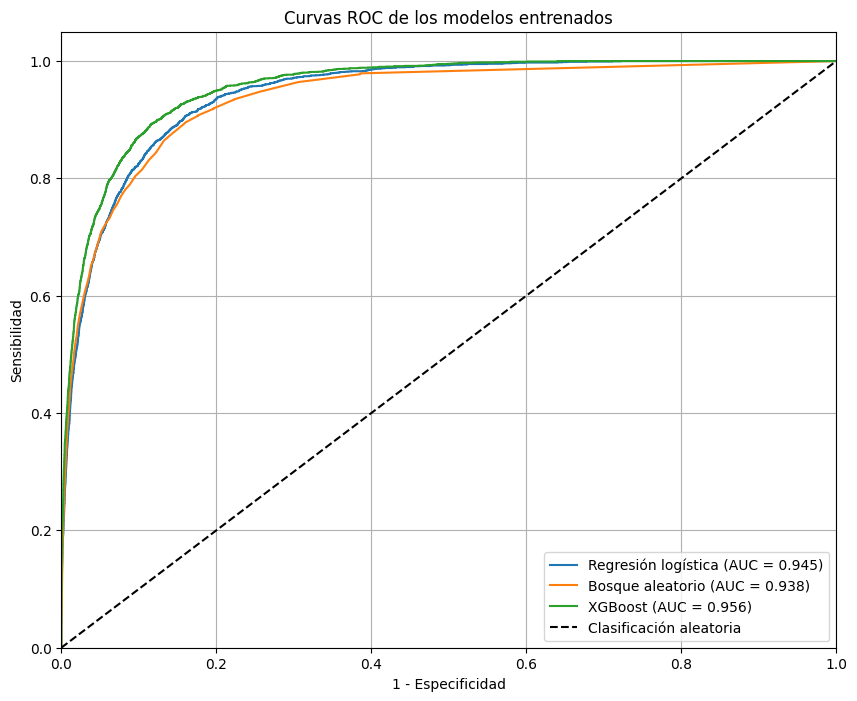

In [112]:
from sklearn.metrics import auc

plt.figure(figsize = (10, 8))

modelos = [
  {
    'nombre' : 'Regresión logística',
    'modelo' : modelo_reg,
    'X_test' : X_test_std,
    'y_test' : y_test_reg
  },
  {
    'nombre' : 'Bosque aleatorio',
    'modelo' : modelo_bosque,
    'X_test' : X_test_bosque,
    'y_test' : y_test_bosque
  },
  {
    'nombre' : 'XGBoost',
    'modelo' : modelo_xgb,
    'X_test' : X_test_xgb,
    'y_test' : y_test_xgb
  }
]

for modelo_info in modelos:
  y_prob_pred = modelo_info['modelo'].predict_proba(modelo_info['X_test'])[:, 1]
  
  fpr, tpr, _ = roc_curve(modelo_info['y_test'], y_prob_pred)
  roc_auc = auc(fpr, tpr)
  
  plt.plot(
    fpr, tpr, label = f'{modelo_info["nombre"]} (AUC = {roc_auc:.3f})'
  )

plt.plot([0, 1], [0, 1], 'k--', label = 'Clasificación aleatoria')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - Especificidad")
plt.ylabel("Sensibilidad")
plt.title('Curvas ROC de los modelos entrenados')
plt.legend(loc = "lower right")
plt.grid()
plt.show()

Del gráfico, notamos que las curvas ROC más cercanas al punto (0, 1),
que representa una exactitud total de 100%, son la asociada a XGBoost;
luego, la curva respectiva al bosque aleatorio; y, por último, la curva
ROC del modelo de regresión logística.

Esto sugiere que el modelo XGBoost podría ser más apropiado para la
predicción.

Por otro lado, los AUC de los modelos son altos, pues son mayores
que 0.9. Asimismo, el máximo AUC se halló para el modelo XGBoost, lo
cual refuerza su elección como el modelo por seleccionar.

### Especificidad y el coeficiente de Kappa

In [113]:
metricas_modelos = pd.DataFrame({
  'Modelo' : [modelo_info['nombre'] for modelo_info in modelos],
  'Exactitud': [None, None, None],
  'Sensibilidad': [None, None, None],
  'Especificidad': [None, None, None],
  'Coef_Kappa_Cohen': [None, None, None]
})

for modelo_index in metricas_modelos.index:
  y_observado = modelos[modelo_index]['y_test']
  y_predicho = modelos[modelo_index]['modelo'].predict(modelos[modelo_index]['X_test'])

  tp, fn, fp, tn = confusion_matrix(y_observado, y_predicho, labels = [1, 0]).ravel()

  metricas_modelos.loc[modelo_index, 'Exactitud'] = (tp + tn) / (tp + fp + tn + fn)
  metricas_modelos.loc[modelo_index, 'Sensibilidad'] = tp / (tp + fn)
  metricas_modelos.loc[modelo_index, 'Especificidad'] = tn / (tn + fp)
  metricas_modelos.loc[modelo_index, 'Coef_Kappa_Cohen'] = cohen_kappa_score(y_observado, y_predicho)

metricas_modelos

,Modelo,Exactitud,Sensibilidad,Especificidad,Coef_Kappa_Cohen
0,Regresión logística,0.95389,0.390347,0.989346,0.478384
1,Bosque aleatorio,0.953991,0.397343,0.990941,0.496285
2,XGBoost,0.942388,0.732861,0.956619,0.587713


Entre los tres modelos, XGBoost produjo el mayor coeficiente de Kappa de 
Cohen, con un valor de aproximadamente 0.59, lo cual indica un nivel
**moderado** de acuerdo entre las observaciones y predicciones.

En ese sentido, el modelo XGBoost nos provee predicciones
que no se deben simplemente al azar ... hecho que se advirtió
en el análisis descriptivo, debido a que el porcentaje de personas
que sí deben pagar impuestos es tan pequeño (aproximadamente 6%).

Asimismo, resaltamos el hecho que el modelo XGBoost balancea mejor
que los otros dos modelos la sensibilidad y especificidad, produciendo
incluso valores mayores que 70% para ambas métricas.

Por último, destacamos el hecho que, pese al balance entre sensibilidad
y especificidad del modelo XGBoost, este produce una especificidad 
relativamente alta (aproximadamente 96%). Esto significa que el 
modelo XGBoost solo asigna erróneamente a 4% de las personas que no
tienen que pagar impuestos, como si sí tuviesen que pagar impuestos.

Minimizar aquel escenario (error de tipo I) es de mayor prioridad que
minimizar los errores de tipo II (asignar como que no debe pagar impuesto
a alquien que sí debe pagar), en el **contexto particular** del conjunto de datos.

Aquello por la posibilidad de demanda legal por parte de personas que
se hubiesen visto en la obligación de tener que pagar impuesto,
según la predicción del modelo, pese a que no era su responsabilidad.

## Selección del modelo

En base a lo expuesto previamente, seleccionamos el modelo XGBoost
como el más adecuado para la predicción de si una persona debe 
pagar impuestos.